# Creating synthetic attrition data with the Python Faker library for attrition predictive modelling

Composition of the dataset for predictive purposes:
- unique employee numbers to serve as index column
- department (HR, Finance, Marketing, Sales, IT, Customer Service, Legal, Project Management)
- province (in Canada)
- hierarchy level (individual contributor, manager/director, senior leadership)
- tenure with the current company (in years)
- previous experience (in years)
- hiring source (agency, direct, employee referral)
- promoted or not yet promoted
- resigned or stayed
- gender (male, female, non-binary)
- ethnicity (caucasian, african descent, indigenous, bi-racial, hispanic, pacific islander, middle eastern, asian)

In [1]:
# importing data creation libraries
from faker import Faker
from faker.providers import DynamicProvider
from random import choices
import random

# data manipulation & analysis libraries
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# creating a Canadian Faker instance
fake= Faker(locale= 'en_CA')

In [2]:
# creating the list of hierarchy levels with their weights
hierarchy_pool = ["Individual contributor",
                  "Manager/Director",
                  "Senior Leadership"]
h_wts=[0.79,
       0.16,
       0.05]

# creating the list of genders with their weights
gender_pool = ["male",
               "female",
               "non-binary"]
g_wts=[0.49,
       0.49,
       0.02]

# creating the list of ethnicities with their weights
ethnicity_pool = ["caucasian", "african descent",
                  "indigenous", "bi-racial",
                  "hispanic", "pacific islander",
                  "middle eastern", "asian"]
e_wts=[0.61, 0.04,
       0.06, 0.03,
       0.03, 0.01,
       0.02, 0.2]

# creating the list of hiring sources with their weights
source_pool = ["agency",
               "direct",
               "referral"]
s_wts=[0.2,
       0.5,
       0.3]

# creating the list of departments
department_pool = ["HR","Finance","Marketing","Sales",
                   "IT","Customer Service","Legal",
                   "Project Management"]

In [3]:
# creating a function to generate employee records
def create_employees(num_employees):
    employee_list = []
    for i in range(num_employees + 1):
        employee = {}
        employee['ee#'] = 10000000+i
        employee['age'] = random.randint(25,70)
        department = random.choices(department_pool,
                                    k= 1)[0]
        employee['department'] = department
        employee['province'] = fake.province()
        level = random.choices(hierarchy_pool,
                               weights= h_wts,
                               k= 1)[0]
        employee['level'] = level
        gender = random.choices(gender_pool,
                                weights= g_wts,
                                k= 1)[0]
        employee['gender'] = gender
        ethnicity = random.choices(ethnicity_pool,
                                   weights= e_wts,
                                   k= 1)[0]
        employee['ethnicity'] = ethnicity
        source = random.choices(source_pool,
                                weights= s_wts,
                                k= 1)[0]
        employee['hire_source'] = source
        employee['promotion'] = random.choices(["promoted", "not_promoted"],
                                              weights= [0.60, 0.40])
        employee['tenure'] = round(random.uniform(0,30),1)
        employee['previous_xp'] = round(random.uniform(0,30),1)  

# ensuring realism with total work experience < 40 years
        total_xp = employee['tenure'] + employee['previous_xp']
        if total_xp >40:
            excess_xp = total_xp - 40
            if employee['tenure'] > employee['previous_xp']:
                employee['tenure'] = max(employee['tenure'] \
                                         - excess_xp, 0)
            else:
                employee['previous_xp'] = max(employee['previous_xp'] \
                                              - excess_xp, 0)

# ensuring realism between age & total experience
        total_xp = employee['tenure'] + employee['previous_xp']
        max_xp = employee['age'] - 25
        if total_xp > max_xp:
            excess_xp = total_xp - max_xp
            if employee['tenure'] > employee['previous_xp']:
                employee['tenure'] = max(employee['tenure'] \
                                         - excess_xp, 0)
            else:
                employee['previous_xp'] = max(employee['previous_xp'] \
                                              - excess_xp, 0)
        employee['total_xp'] = employee['tenure'] \
                                + employee['previous_xp']
        employee_list.append(employee)
    return pd.DataFrame(employee_list)

In [4]:
# creating a dataframe to hold the output of the function
# and visualize it to check for correct output
attrition = create_employees(2000000)
print(attrition.shape)
print(attrition.columns)
attrition.sample(n=5)

(2000001, 12)
Index(['ee#', 'age', 'department', 'province', 'level', 'gender', 'ethnicity',
       'hire_source', 'promotion', 'tenure', 'previous_xp', 'total_xp'],
      dtype='object')


,ee#,age,department,province,level,gender,ethnicity,hire_source,promotion,tenure,previous_xp,total_xp
745292,10745292,48,Sales,Yukon Territory,Manager/Director,male,caucasian,direct,[not_promoted],2.5,1.8,4.3
1941441,11941441,39,Project Management,Nunavut,Individual contributor,male,indigenous,direct,[promoted],0.0,15.0,15.0
1252478,11252478,41,IT,Quebec,Individual contributor,female,caucasian,referral,[not_promoted],3.8,6.3,10.1
1204716,11204716,29,Legal,Saskatchewan,Individual contributor,male,caucasian,direct,[not_promoted],4.0,0.0,4.0
1290861,11290861,41,HR,Nova Scotia,Senior Leadership,female,indigenous,direct,[not_promoted],20.0,0.0,20.0


## Exploratory data analysis

In [5]:
# categorical data profiling with formatted outputs
def category_profiling(df, cat_columns):
    print(df.dtypes)
    print("---")
    for col in cat_columns:
        percentages = df[col].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
        print(percentages)
        print("---")

cat_columns = ['department', 'province', 'level', \
               'gender', 'ethnicity', 'hire_source', 'promotion']

category_profiling(attrition, cat_columns)

ee#              int64
age              int64
department      object
province        object
level           object
gender          object
ethnicity       object
hire_source     object
promotion       object
tenure         float64
previous_xp    float64
total_xp       float64
dtype: object
---
department
Marketing             12.5%
Project Management    12.5%
HR                    12.5%
Finance               12.5%
IT                    12.5%
Legal                 12.5%
Sales                 12.5%
Customer Service      12.5%
Name: proportion, dtype: object
---
province
Prince Edward Island         7.7%
Northwest Territories        7.7%
New Brunswick                7.7%
British Columbia             7.7%
Nunavut                      7.7%
Alberta                      7.7%
Yukon Territory              7.7%
Saskatchewan                 7.7%
Nova Scotia                  7.7%
Quebec                       7.7%
Manitoba                     7.7%
Newfoundland and Labrador    7.7%
Ontario           

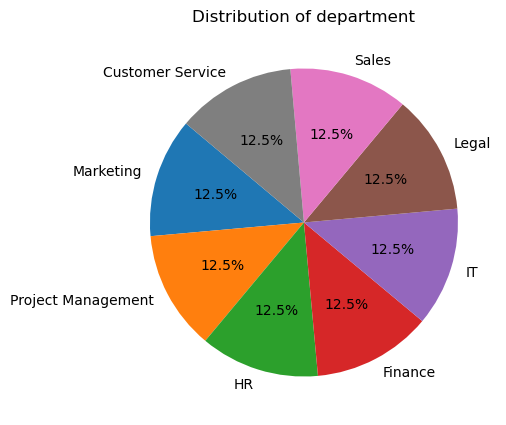

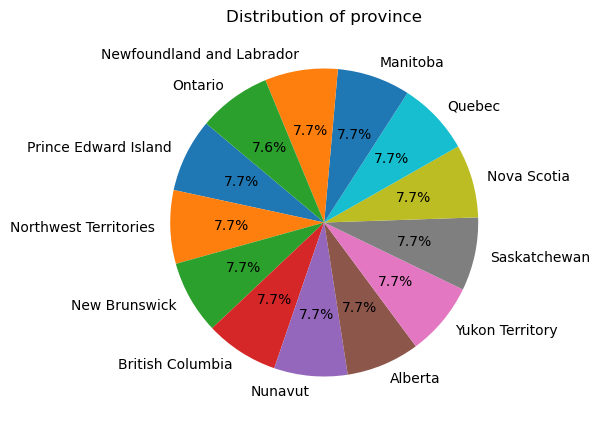

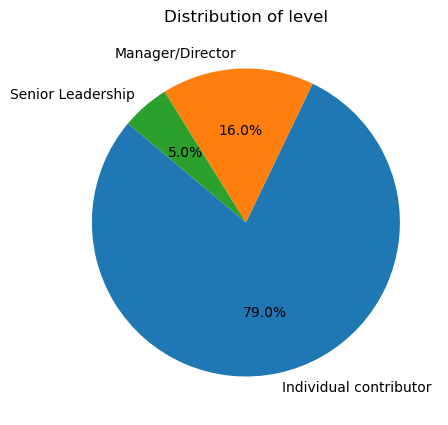

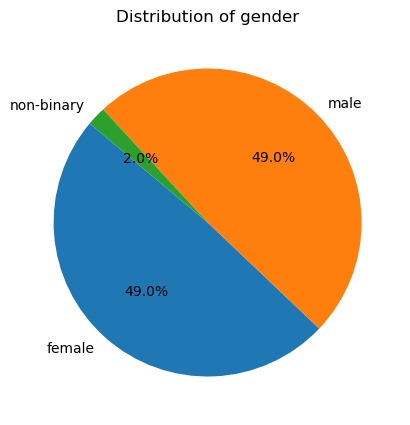

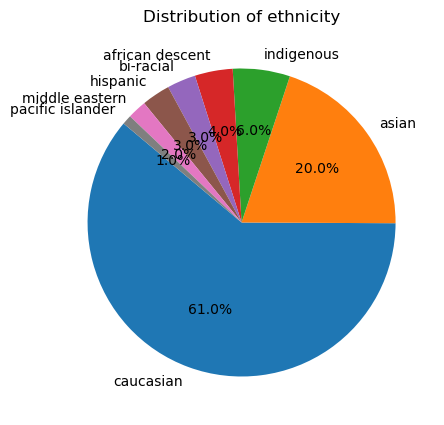

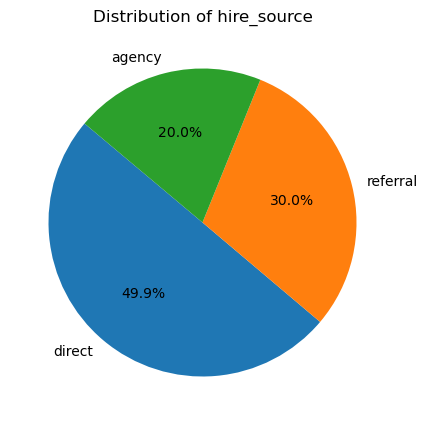

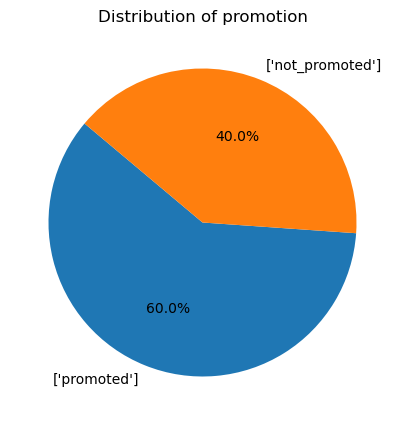

In [6]:
# plotting categorical columns' distributions
def cat_distribution_plots(data, cat_columns):
    for col in cat_columns:
        graph_data= data[col].value_counts()

        plt.figure(figsize= (10,5))
        plt.pie(graph_data.values,
                labels= graph_data.index,
                autopct= '%1.1f%%',
                startangle= 140)
        plt.title(f'Distribution of {col}')
        plt.show()

cat_distribution_plots(attrition, cat_columns)

In [7]:
# numerical data profiling with formatted outputs
def numerical_profiling(df,num_columns):
    for col in num_columns:
        column = df[col]
        stats = {
            "min": column.min(),
            "max": column.max(),
            "avg": column.mean().round(0),
            "stdev": column.std(),
            "1st quartile": np.percentile(a= column, q= 25),
            "2nd quartile": np.percentile(a= column, q= 50),
            "3rd quartile": np.percentile(a= column, q= 75),
            "skew": skew(column, axis=0, bias=True),
            "kurtosis": kurtosis(column, axis=0, 
                                 fisher=True, bias=True)}
        
        print(f"Statistics for {col.capitalize()}:")
        for stat, value in stats.items():
            print(f"{stat}: {value}")
        print("---")

num_columns = ['tenure', 'previous_xp', 'total_xp', 'age']

numerical_profiling(attrition, num_columns)

Statistics for Tenure:
min: 0.0
max: 30.0
avg: 10.0
stdev: 7.363044112179338
1st quartile: 3.3
2nd quartile: 9.2
3rd quartile: 15.6
skew: 0.37296741390123617
kurtosis: -0.7961941516215996
---
Statistics for Previous_xp:
min: 0.0
max: 30.0
avg: 10.0
stdev: 7.356422821388785
1st quartile: 3.3
2nd quartile: 9.2
3rd quartile: 15.6
skew: 0.3738225765040813
kurtosis: -0.7900686287481107
---
Statistics for Total_xp:
min: 0.0
max: 40.0
avg: 20.0
stdev: 9.597625589092974
1st quartile: 12.4
2nd quartile: 18.6
3rd quartile: 26.7
skew: 0.3002290808821658
kurtosis: -0.6750555890620795
---
Statistics for Age:
min: 25
max: 70
avg: 48.0
stdev: 13.281703017256422
1st quartile: 36.0
2nd quartile: 48.0
3rd quartile: 59.0
skew: -8.30760325447725e-05
kurtosis: -1.2023522352812137
---


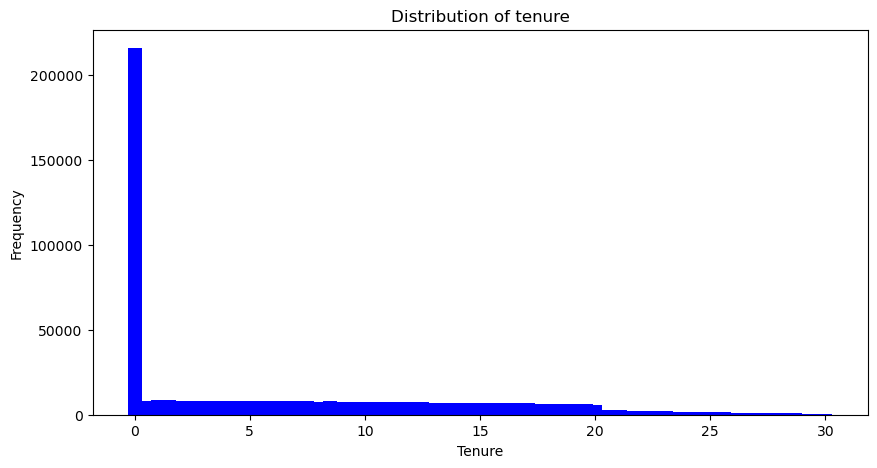

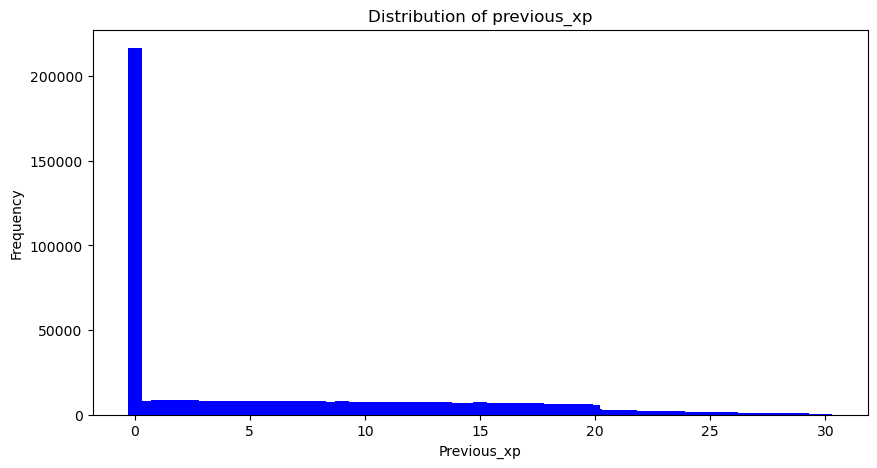

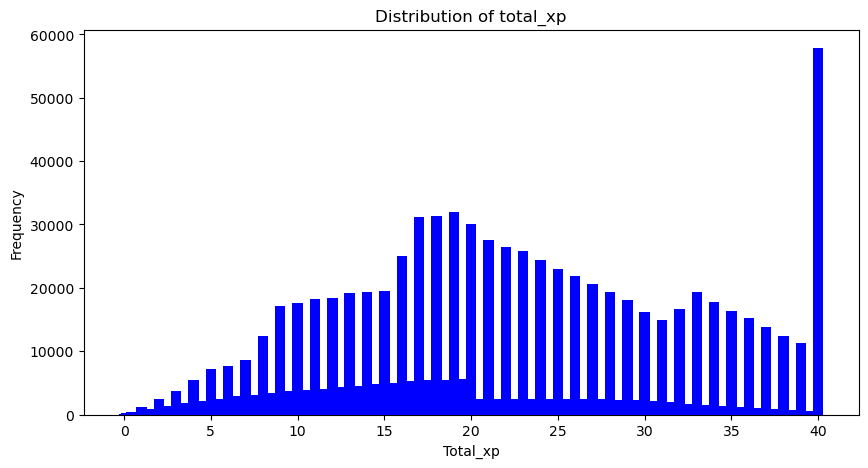

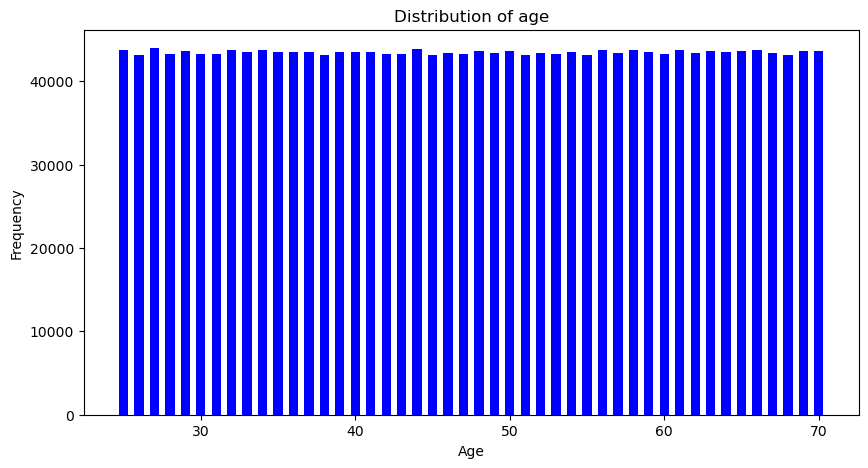

In [8]:
# plotting numerical columns' distributions
def num_distribution_plots(data, num_columns):
    for col in num_columns:
        graph_data = data[col].value_counts().sort_index()

        plt.figure(figsize= (10,5))
        plt.bar(graph_data.index,
                graph_data.values,
                color= 'blue',
                width= 0.6)
        plt.xlabel(col.capitalize())
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.show()

num_distribution_plots(attrition, num_columns)

## Exporting the dataframe as a .csv file

In [9]:
# export the dataframe to .csv file
attrition.to_csv('attrition_df.csv',index=False)